In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as inter 
import scipy.integrate as integrate
from scipy.integrate import quad, nquad
from scipy.special import ellipe
from scipy.special import ellipk

In [2]:
# Parameters for Galaxy NGC 5533
G = 4.300e-6                                                #gravitational constant (kpc/solar mass*(km/s)^2)
h = 8.9                                                     #radial scale-length (kpc)
#rho00 = 0.31e9                                              #central 3D density (solar mass/kpc^2) 
epsdisk = 5.0                                               #mass-to-light ratio disk
absmag = -22.02                                             #absolute magnitude 
magsun = 4.42                                               #absolute magnitude of the sun

z0 = lambda h: 0.2*h                                        #half-thickness (kpc)
R = lambda h: 4*h                                           #cut-off radius (kpc)
d = lambda h: 0.2*h                                         #cut-off length upper limits (kpc)

[1.64006981e-02 3.88501738e+00 7.87588903e+00 1.17575631e+01
 1.57546738e+01 1.96291348e+01 2.37401817e+01 2.75064980e+01
 3.13903044e+01 3.56194206e+01 3.93728638e+01 4.35945825e+01
 4.73517376e+01 5.12228289e+01 5.52093832e+01 5.94341030e+01
 6.33070897e+01 6.70612174e+01 7.11660515e+01 7.50371691e+01
 7.91434774e+01 8.31321114e+01 8.70029394e+01 9.09909416e+01]


C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:226: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


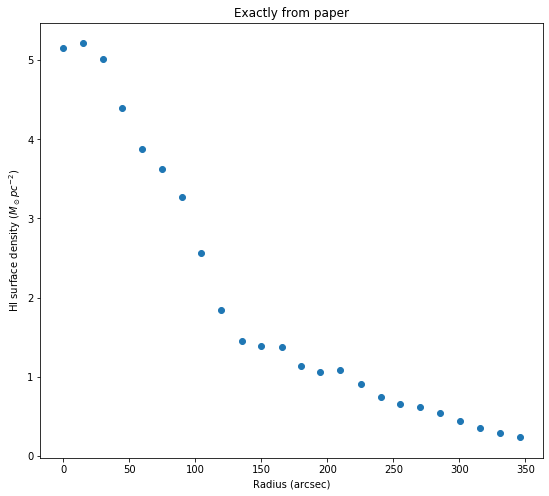

In [3]:
# H1 surface mass density data from https://www.aanda.org/articles/aa/full/2005/40/aa3172-05/aa3172-05_online.html
# Used DataThief to get data from image
h1data = np.loadtxt("../5533_h1_data/h1data.txt")
rarcsec, h1smd = h1data.T

# Convert pc to kpc
h1smd = h1smd*1e6

# Converting arcseconds to kpc for radius measurements
D = 54.3                                    # distance in Mpc
rkpc = rarcsec*D*1000/206265                # calculated using http://astro.physics.uiowa.edu/ITU/glossary/small-angle-formula/
print(rkpc)

# Does this measured H1 data equal rho00?
rho00data = inter.UnivariateSpline(rkpc, h1smd, k=3)

# Convert univariate spline to function
def rho0function(r):
    return rho00data(r)

# Plot HI surface density
plt.figure(figsize=(9,8))
plt.scatter(rarcsec,h1smd*1e-6)
plt.title("Exactly from paper")
plt.xlabel("Radius (arcsec)")
plt.ylabel("HI surface density ($M_\odot pc^{-2}$)")
plt.show()

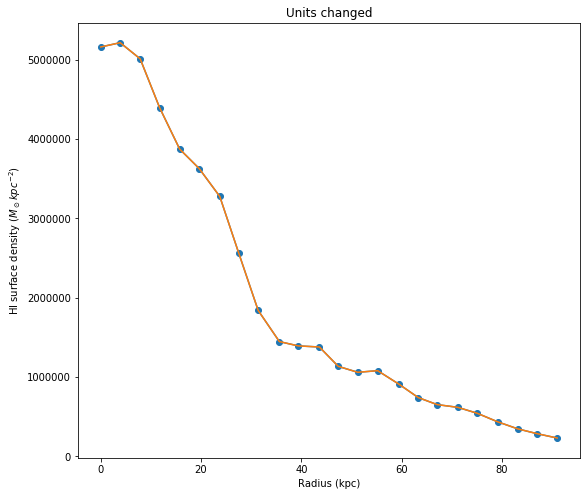

In [4]:
# Plot HI surface density
plt.figure(figsize=(9,8))
plt.scatter(rkpc,h1smd)
plt.plot(rkpc,rho00data(rkpc))
plt.plot(rkpc,rho0function(rkpc))
plt.title("Units changed")
plt.xlabel("Radius (kpc)")
plt.ylabel("HI surface density ($M_\odot kpc^{-2}$)")
plt.show()

In [5]:
# Definitions
def x(r,u,xi):
    return ((r**2)+(u**2)+(xi**2))/(2*r*u)

def px(r,u,xi):
    return x(r,u,xi)-(np.sqrt((x(r,u,xi)**2)-1))

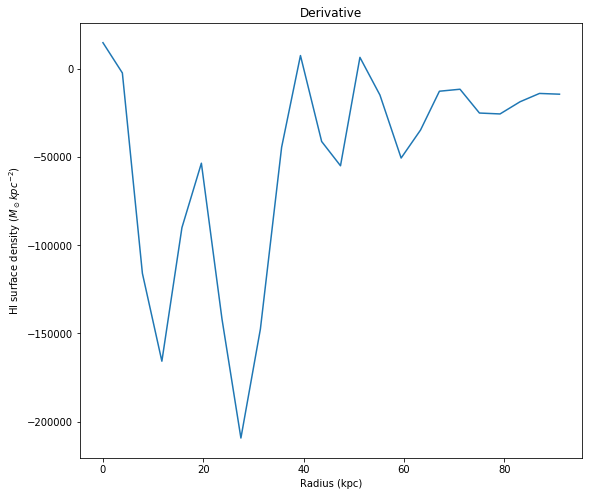

In [6]:
# Derivative of the splined traced data
drho0 = rho00data.derivative()

# Plot HI surface density
plt.figure(figsize=(9,8))
plt.plot(rkpc,drho0(rkpc))
plt.title("Derivative")
plt.xlabel("Radius (kpc)")
plt.ylabel("HI surface density ($M_\odot kpc^{-2}$)")
plt.show()

def drho0function(r):
    return drho0(r)

In [7]:
# Defining disk density distribution
def rhodata_rz(r,z,h):
    return rho0function(r)*(np.power(np.cosh(z/z0(h)), (-2)))

def drhodata_rz(r,z,h):
    return drho0function(r)*(np.power(np.cosh(z/z0(h)), (-2)))

print(type(drho0function))

<class 'function'>


In [8]:
#complete elliptic integral
def K(r,u,xi):
    K = ellipk(px(r,u,xi)) - ellipe(px(r,u,xi))
    return K

In [9]:
#inner function
def innerfunc(z,r,u,h): 
    innerf = (2*np.sqrt(u)*K(r,u,z)*drhodata_rz(u,z,h))/(np.pi*np.sqrt(r*px(r,u,z)))
    return innerf

In [10]:
#integrate inner function
def innerintegral(u,r,h):
    return quad(innerfunc, 0, R(h)+d(h), args=(r,u,h))[0]

In [11]:
#integrate outer function
def outerintegral(r,h):
    return quad(innerintegral, 0, np.inf, args=(r,h))[0]

In [12]:
#Radial force
def radialforce(r,h):
    F = 4*np.pi*G*outerintegral(r,h)
    return F

In [13]:
#disk velocity
rd = np.linspace(0.1, 1000, num=500)
Fv = np.vectorize(radialforce)

def d_v(r,h):
    v = np.sqrt(-r*Fv(r,h))
    return v

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: Inte

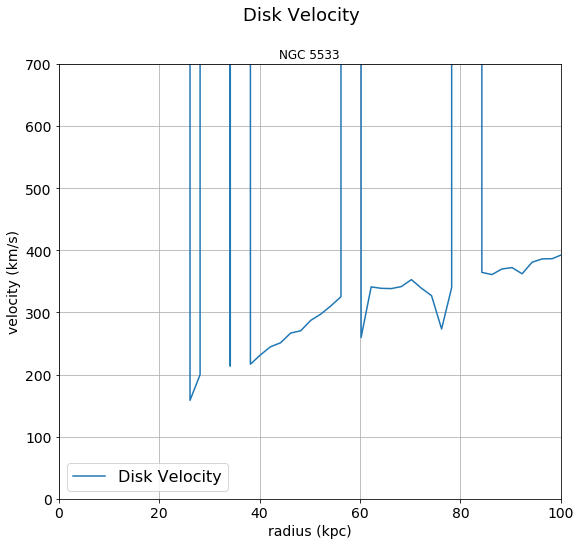

In [14]:
#plot disk velocity
fig = plt.figure(figsize=(9.0,8.0))                #size of the plot
ax = plt.axes()
ax.grid(True)
ax.yaxis.grid(True,which='minor',linestyle='--')

plt.plot(rd, d_v(rd,h), linestyle='solid', label='Disk Velocity')

plt.axis('tight');

fig.suptitle('Disk Velocity', fontsize=18)
ax.set(title='NGC 5533')              #labeling axes
ax.set_xlim(0,100)
ax.set_ylim(0,700)
ax.set_xlabel('radius (kpc)', fontsize=14)
ax.set_ylabel('velocity (km/s)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14);

plt.legend(fontsize=16);                                   #adding legend
#plt.savefig('DiskVelocity100pts.png')
plt.show()